<a href="https://colab.research.google.com/github/hecshzye/crypto-price-predictions-2022/blob/main/crypto_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  💲 Bitcoin Price Prediction using Deep Learning 💲

- Time series forecasting using TensorFlow to predict the price of Bitcoin (BTC) 

- The dataset used in this project is from CoinDesk: https://www.coindesk.com/price/bitcoin/

- Link to the dataset used (2014/03/11-2022/01/18): https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv


- **`LEGAL NOTE`** ⚠️
     
     - **`Bitcoin (BTC) Price Prediction Using Deep Learning` project and its   `findings, conclusions and models` are `STRICTLY NOT FINANCIAL ADVICE` in any manner.**

     - **`ANY FINDINGS AND PREDICTIONS DERIVED FROM THIS MODEL IS ONLY FOR EDUCATIONAL, LEARNING AND RESEARCH PURPOSES`.**


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import tensorflow as tf
import csv
import datetime

In [4]:
# helper function pre-written
!wget https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/helper_functions.py

--2022-01-18 08:14:39--  https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6442 (6.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.29K  --.-KB/s    in 0s      

2022-01-18 08:14:39 (48.8 MB/s) - ‘helper_functions.py’ saved [6442/6442]



In [5]:
from helper_functions import create_tensorboard_callback, create_confusion_matrix, plot_loss_curves

# Data import and Exploratory Data Analysis 

In [6]:
# dataset import
!wget https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv

--2022-01-18 08:16:53--  https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156982 (153K) [text/plain]
Saving to: ‘BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv’

BTC_USD_2014-11-04_ 100%[===================>] 153.30K  --.-KB/s    in 0.02s   

2022-01-18 08:16:53 (8.70 MB/s) - ‘BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv’ saved [156982/156982]



In [7]:
# EDA & Preprocessing
df = pd.read_csv("/content/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145
2014-11-09,BTC,344.745289,341.459753,346.475560,340.357542
2014-11-10,BTC,357.239982,344.745289,357.986991,342.082083
2014-11-11,BTC,371.116917,371.116917,371.116917,371.116917
2014-11-12,BTC,366.664633,367.921363,370.800015,361.225098


In [9]:
df.info(), len(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2014-11-04 to 2022-01-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2633 non-null   object 
 1   Closing Price (USD)  2633 non-null   float64
 2   24h Open (USD)       2633 non-null   float64
 3   24h High (USD)       2633 non-null   float64
 4   24h Low (USD)        2633 non-null   float64
dtypes: float64(4), object(1)
memory usage: 123.4+ KB


(None, 2633)

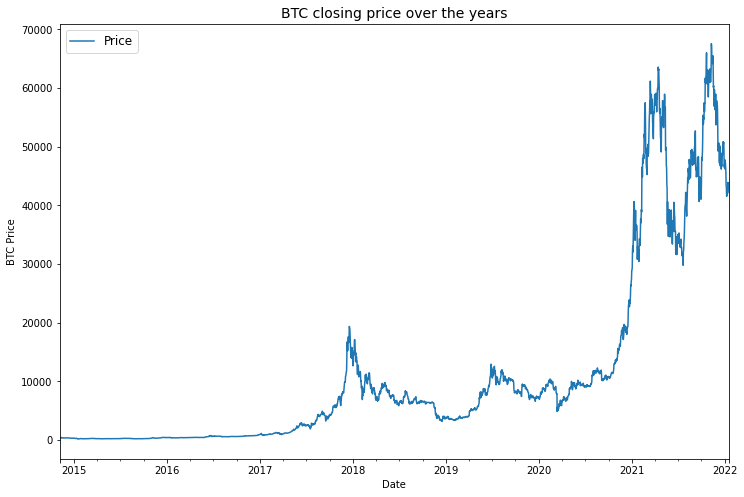

In [10]:
# EDA, checking for closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.plot(figsize=(12, 8))
plt.ylabel("BTC Price")
plt.title("BTC closing price over the years", fontsize=14)
plt.legend(fontsize=12);